### **Imports**

In [1]:
import keras
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, LeakyReLU
from keras import layers
from keras import optimizers, activations
from keras import regularizers
from keras import initializers
from keras.models import Model

from sklearn import metrics
import tensorflow as tf
import tensorflow.keras

from sklearn.model_selection import KFold

import os


Using TensorFlow backend.


## **setup seed for Numpy**

In [0]:
seed = 8000

np.random.seed(seed)
np.random.RandomState(seed)
tf.random.set_seed(seed)

## **Load Data**

In [0]:
data = sio.loadmat('/content/drive/My Drive/Colab Notebooks/emt_valence_sample.mat')

In [0]:
train_x_ =  data["train_x"]
train_y_ = data["train_y"]
test_x_  = data["test_x"]
test_y_  = data["test_y"]

In [5]:
print('x_train: ', train_x_.shape)
print('y_train: ', train_y_.shape)
print('x_test: ', test_x_.shape)
print('y_test: ', test_y_.shape)

x_train:  (64, 55417)
y_train:  (1, 64)
x_test:  (16, 55417)
y_test:  (1, 16)


In [0]:
#print(train_y_)

In [0]:
#print(test_y_)

In [0]:
#print(test_x_)  # p-value of voxels   (16 volume * 55417 voxel)

## **X & Y**

In [9]:
X = np.vstack([train_x_, test_x_])   #total_x
Y = np.hstack([train_y_, test_y_])   #total_y
Y = Y.T / 10


print('X: ', X.shape)
print('Y: ', Y.shape)

X:  (80, 55417)
Y:  (80, 1)


# **Parameters of DNN**

In [0]:
[n_in, n_hidden1, n_hidden2, n_hidden3, n_output] = [55417, 20, 20, 20, 1] 

n_epochs = 100      # the total number of epoch
batch_size = 2      # batch size 

#l_rate = 0.002    # learning rate 
#momentum = 0.01     # momentum
#dcay_rate = 0.99    # decay learning rate for the learning rate 

k_folds = 5

# **Plot Function**

In [0]:
def plot_history(net_history):

    history = net_history.history
    losses = history['loss']

    MSE = history['mse']

    MAE = history['mae']

    
    plt.figure(figsize=(10, 5), dpi=100)
    plt.legend(loc='best', fontsize='large')
    plt.grid(color='#ddd', ls = '-', lw = 0.5)
    plt.xlim(0, n_epochs)
    plt.ylim(0, )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses)
    #plt.plot(val_loss)
    #plt.legend(['Loss', 'val_Loss'])
    
    plt.figure(figsize=(10, 5), dpi=100)
    plt.legend(loc='best', fontsize='large')
    plt.grid(color='#ddd', ls = '-', lw = 0.5)
    plt.xlim(0, n_epochs)
    plt.ylim(0, )
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.plot(MSE)
    #plt.plot(val_MSE)
    #plt.legend(['MSE', 'val_MSE'])


    plt.figure(figsize=(10, 5), dpi=100)
    plt.legend(loc='best', fontsize='large')
    plt.grid(color='#ddd', ls = '-', lw = 0.5)
    plt.xlim(0, n_epochs)
    plt.ylim(0, )
    
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.plot(MAE)
    #plt.plot(val_MAE)
    #plt.legend(['MAE', 'val_MAE'])


# **Custom Metrics**

In [0]:
import keras.backend as K

def tf_pearson(y_true, y_pred):
  #return tf.compat.metrics.streaming_pearson_correlation(y_pred, y_true)[1]
  return tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)
  
def mean_pred(y_true, y_pred):
  return K.mean(y_pred)


def STD_pred(y_true, y_pred):
  return K.std(y_pred)

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis= -1))
 

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))


# **Callbacks**

In [13]:
class prediction_history(keras.callbacks.Callback):
    def __init__(self):
        self.pred_train = []
        self.pred_test  = []


    def on_epoch_end(self, epoch, logs={}):
        self.pred_train.append(model.predict(x_train))
        self.pred_test.append(model.predict(x_test))


from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', 
                         histogram_freq= 1,
                         write_graph= True,
                         write_grads= True,
                         batch_size= batch_size,
                         write_images= True)        

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '
/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


# **Create & Compile Model**

In [0]:
def create_model():

  # Input layer (55417 feature --> 55417 input node)
  x_in = layers.Input(shape = (x_train.shape[1], ))  


  L1 = layers.Dense(n_hidden1, activation = activations.relu,
                    kernel_initializer = initializers.he_uniform()  # glorot_uniform for tanh
                    )(x_in)   


  D1 = layers.Dropout(0.00)(L1)  #0.001

  L2 = layers.Dense(n_hidden2, activation = activations.relu,
                    kernel_initializer = initializers.he_uniform()
                    )(D1)

  D2 = layers.Dropout(0.1)(L2)


  L3 = layers.Dense(n_hidden3, activation = activations.relu,
                    kernel_initializer = initializers.he_uniform()
                    )(D2)

  D3 = layers.Dropout(0.2)(L3)

  y_out = layers.Dense(n_output, activation = activations.linear,
                      kernel_initializer = initializers.uniform()
                      )(D3)  # Output layer  1 output node)


  #Create Model
  model = Model(x_in, y_out)



  # SGD(lr= 0.005, decay= 0.8, momentum= 0.01)  good
  # Adamax(lr= 0.00001, beta_1= 0.9, beta_2= 0.999)
  # rmsprop(learning_rate= 0.001)
  # Adadelta(learning_rate= 0.001, rho= 0.95)  bad
  # Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999)  good

  model.compile(optimizers.Adamax(lr= 0.001, beta_1= 0.9, beta_2= 0.999), 
              loss= keras.losses.mean_squared_error,
              metrics= ['mse', 'mae', 'mape', rmse, r_square, mean_pred, STD_pred])
  


  return model


#model.summary()

# **Cross Validation**

In [15]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits= k_folds, shuffle= True, random_state= 0)

MSEs  = []
MAEs  = []
MAPEs = []
RMSEs = []
CCs   = []

for train_index, test_index in KFold(n_splits = k_folds, shuffle= True, random_state= 0).split(X, Y):

  x_train, x_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]


  # Create model
  model = create_model()

  # callbacks
  cbk = prediction_history()

  # Train model
  network_history = model.fit(x_train, y_train,
                      epochs= n_epochs,
                      batch_size= batch_size,
                      callbacks = [cbk],
                      verbose = 1
                    )
  
  # evaluate the model
  scores = model.evaluate(x_test, y_test, verbose= 0)


  print("%s: %.2f" % (model.metrics_names[1], scores[1] ))   #MSE
  MSEs.append(scores[1])

  print("%s: %.2f" % (model.metrics_names[2], scores[2] ))   #MAE
  MAEs.append(scores[2])

  print("%s: %.2f" % (model.metrics_names[3], scores[3] ))   #MAPE
  MAPEs.append(scores[3])

  print("%s: %.2f" % (model.metrics_names[4], scores[4] ))   #RMSE
  RMSEs.append(scores[4])

  print("%s: %.2f" % (model.metrics_names[5], scores[5] ))   #r_square
  CCs.append(scores[5])



Epoch 1/100
64/64 [==============================] - 1s 9ms/step - loss: 0.2726 - mse: 0.2726 - mae: 0.4156 - mape: 102.0374 - rmse: 0.4156 - r_square: 461887.1250 - mean_pred: 0.3317 - STD_pred: 0.1628
Epoch 2/100
64/64 [==============================] - 0s 6ms/step - loss: 0.1429 - mse: 0.1429 - mae: 0.2857 - mape: 72.9418 - rmse: 0.2857 - r_square: 1409383.2500 - mean_pred: 0.4623 - STD_pred: 0.1924
Epoch 3/100
64/64 [==============================] - 0s 6ms/step - loss: 0.1903 - mse: 0.1903 - mae: 0.3253 - mape: 79.7910 - rmse: 0.3253 - r_square: 739266.7500 - mean_pred: 0.3439 - STD_pred: 0.1744
Epoch 4/100
64/64 [==============================] - 0s 7ms/step - loss: 0.1011 - mse: 0.1011 - mae: 0.2378 - mape: 59.7886 - rmse: 0.2378 - r_square: 340035.7500 - mean_pred: 0.3593 - STD_pred: 0.1503
Epoch 5/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0820 - mse: 0.0820 - mae: 0.2392 - mape: 64.0581 - rmse: 0.2392 - r_square: 366936.7188 - mean_pred: 0.3747 - STD_p

# **Model Evaluation**

## **Train**

In [16]:
#losses = history['loss']
#MSE = history['mse']
#MAE = history['mae']
#MAPE = history['mape']

pred_train = model.predict(x_train)
train_mse = metrics.mean_squared_error(y_train, pred_train)
train_mae = metrics.mean_absolute_error(y_train, pred_train)
#train_mape = metrics.(y_train, pred_train)

print('MSE for Train: %.2f' % (train_mse))
print('\nRMSE for Train: %.2f' % (np.sqrt(metrics.mean_squared_error(y_train, pred_train)) ))
print('\nMAE for Train: %.2f' % (train_mae))
#print('\nMAPE for Train: %.2f' % (train_mape))

MSE for Train: 0.01

RMSE for Train: 0.08

MAE for Train: 0.07


## **Test**

In [17]:
print("MSE:  %.2f (+/-) %.2f" % (np.mean(MSEs) , np.std(MSEs) ))
print("MAE:  %.2f (+/-) %.2f" % (np.mean(MAEs) , np.std(MAEs) ))
print("RMSE: %.2f (+/-) %.2f" % (np.mean(RMSEs), np.std(RMSEs)))
print("MAPE: %.2f (+/-) %.2f" % (np.mean(MAPEs), np.std(MAPEs)))
print("CC:   %.2f (+/-) %.2f" % (np.mean(CCs)  , np.std(CCs)  ))


MSE:  0.03 (+/-) 0.01
MAE:  0.15 (+/-) 0.02
RMSE: 0.15 (+/-) 0.02
MAPE: 36.12 (+/-) 1.44
CC:   1.37 (+/-) 0.39


In [0]:
ptrain_list = cbk.pred_train
ptest_list  = cbk.pred_test

#print(ptrain_list)

pct_trvld = np.stack(ptrain_list, axis = 0 ).reshape(n_epochs, x_train.shape[0])
pct_tst   = np.stack(ptest_list,  axis = 0 ).reshape(n_epochs, x_test.shape[0])
#print(pct_tst)

# **Plots**

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


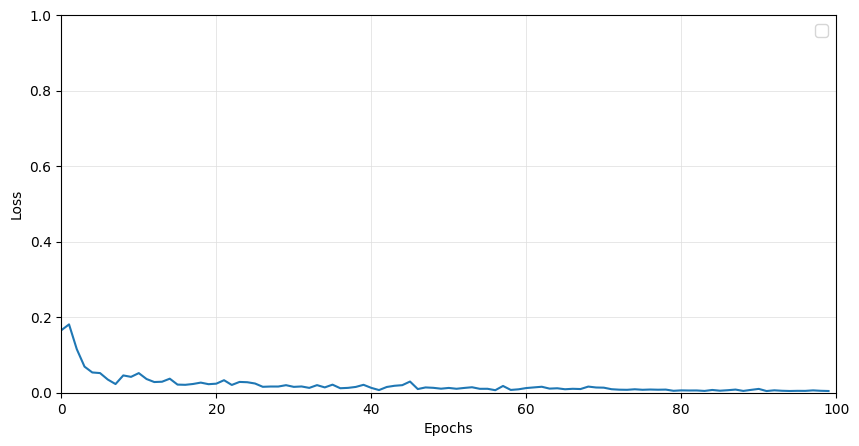

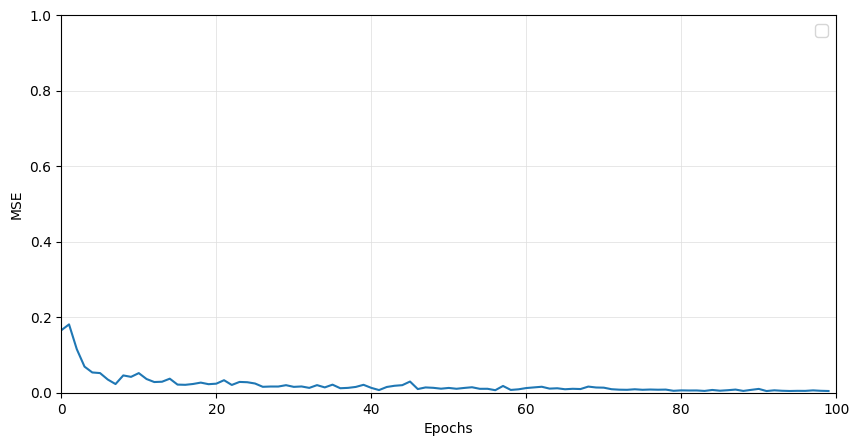

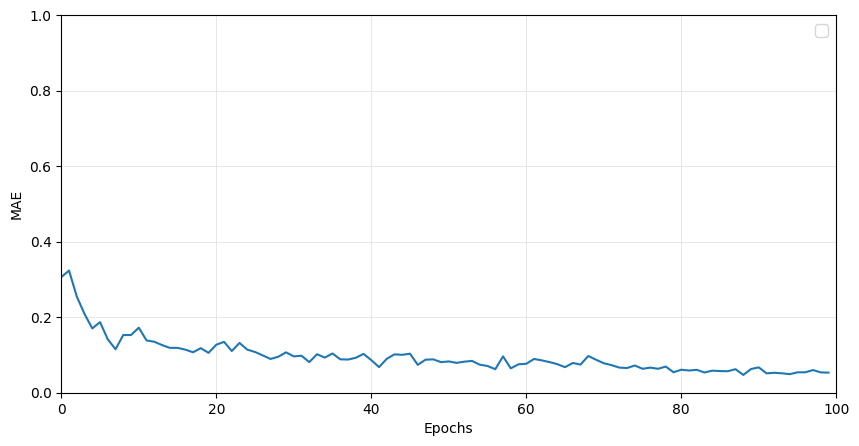

In [19]:
history = network_history.history 

plot_history(network_history)

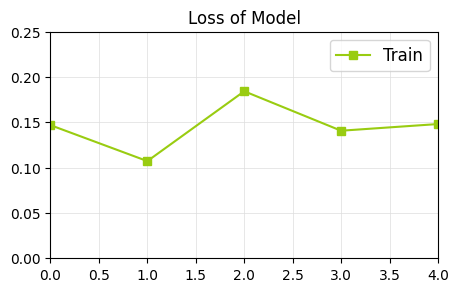

In [20]:
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(MAEs, label='Train', marker='s', color='#99cc11')

#plt.plot(history.history['val_loss'], label='Validation')

plt.title('Loss of Model')
plt.axis([0, k_folds-1, 0, 0.25])
plt.xticks=[1, 2, 3, 4, 5]
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

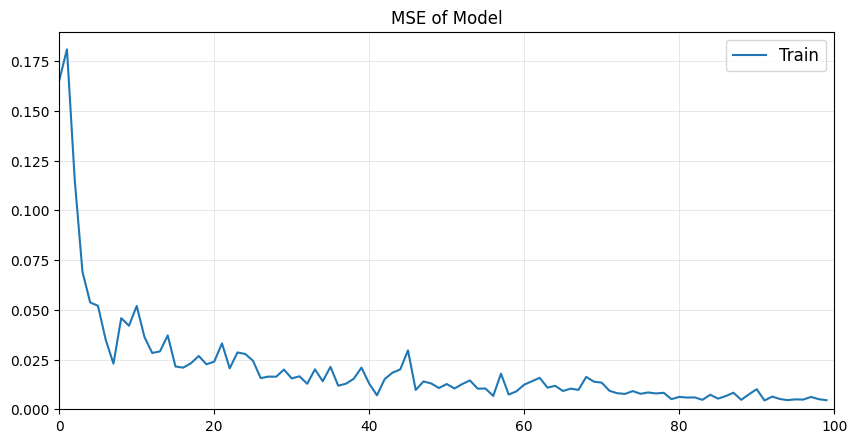

In [21]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(network_history.history['mse'], label='Train')

#plt.plot(network_history.history['val_mse'], label='Validation')

plt.title('MSE of Model')
plt.xlim(0, n_epochs)
plt.ylim(0, )
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

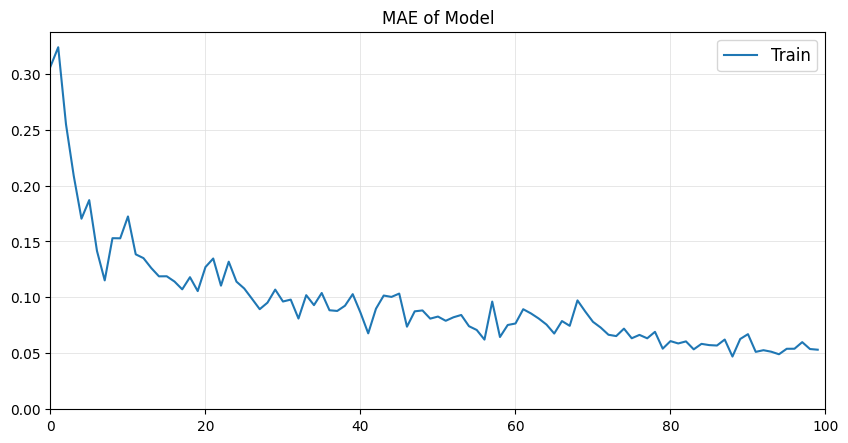

In [22]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(network_history.history['mae'], label='Train')

#plt.plot(network_history.history['val_mae'], label='Validation')

plt.title('MAE of Model')
plt.xlim(0, n_epochs)
plt.ylim(0, )
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

# **Predict Pattern**

Patterns of Estimated Emotion Response from **Training Data**


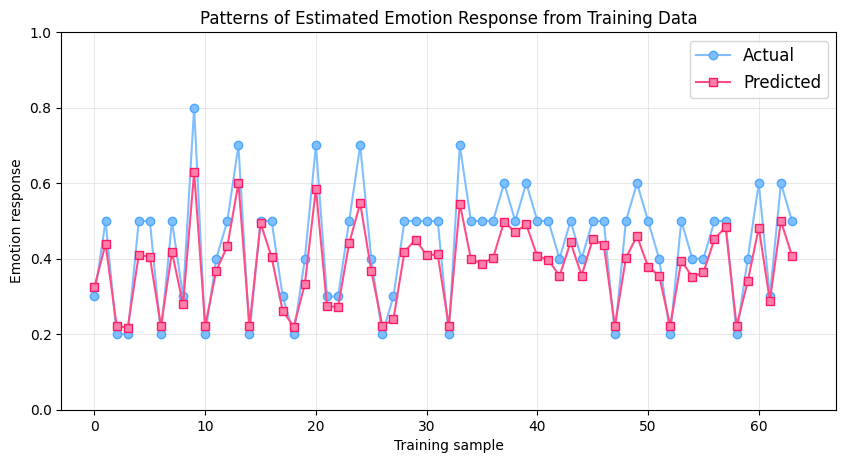

In [23]:
#make preediction
pred_train = model.predict(x_train)

#save prediction
testData = pd.DataFrame(y_train)
preddData = pd.DataFrame(pred_train)


dataF = pd.concat([testData, preddData], axis=1)
dataF.columns =['Real demand','Predicted Demand']
dataF.to_csv('Demandprediction.csv')



plt.figure(figsize=(10, 5), dpi=100)
plt.plot(y_train, label='Actual',color='#80bfff', marker='o', MarkerEdgeColor='#4da6ff',MarkerFaceColor='#80bfff')
plt.plot(pred_train, label='Predicted', marker='s', color='#ff4d88', MarkerEdgeColor='#ff1a66',MarkerFaceColor='#ff80aa')

plt.xlim(-3, y_train.shape[0]+3)
plt.ylim([0, 1])
plt.title('Patterns of Estimated Emotion Response from Training Data')
plt.xlabel('Training sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

Patterns of Estimated Emotion Response from **Test Data**

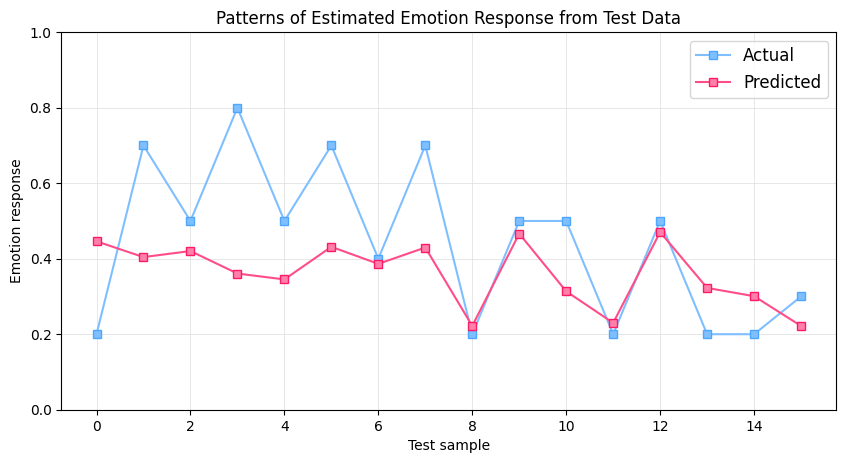

In [24]:
#make preediction
pred = model.predict(x_test)

#save prediction
testData = pd.DataFrame(y_test)
preddData = pd.DataFrame(pred)

dataF = pd.concat([testData, preddData], axis=1)
dataF.columns =['Real demand', 'Predicted Demand']
dataF.to_csv('Demandprediction.csv')


plt.figure(figsize=(10, 5), dpi=100)
plt.plot(y_test, label='Actual', marker='s', color='#80bfff', MarkerEdgeColor='#4da6ff',MarkerFaceColor='#80bfff')
plt.plot(pred, label='Predicted', marker='s', color='#ff4d88', MarkerEdgeColor='#ff1a66',MarkerFaceColor='#ff80aa')
plt.ylim([0, 1])
plt.title('Patterns of Estimated Emotion Response from Test Data')
plt.xlabel('Test sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

In [25]:
#Model error
score_train = model.evaluate(x_train, y_train, batch_size= 2)
score_test = model.evaluate(x_test, y_test, batch_size= 2)

print("in train MSE = ", np.round(score_train, 4))
print("in test MSE = ", np.round(score_test, 4))


16/16 [==============================] - 0s 1ms/step
in train MSE =  [5.90000000e-03 5.90000000e-03 6.51000000e-02 1.39250000e+01
 6.51000000e-02 2.85574453e+04 3.80500000e-01 5.91000000e-02]
in test MSE =  [ 0.0366  0.0366  0.1482 35.0613  0.1482  2.0587  0.3608  0.0491]


# **Correlation Coefficient**

In [0]:
# Calculate the correlation coefficients over epochs 
tr_cc = np.zeros((n_epochs))
ts_cc = np.zeros((n_epochs))

for i in range(n_epochs - 1):
    tr_r = np.corrcoef(pct_trvld[i, :], y_train.T)
    ts_r = np.corrcoef(pct_tst[i, :], y_test.T)

    tr_cc[i] = tr_r[1, 0]
    ts_cc[i] = ts_r[1, 0]

CC for Train: 0.98
CC fot Test:  0.53




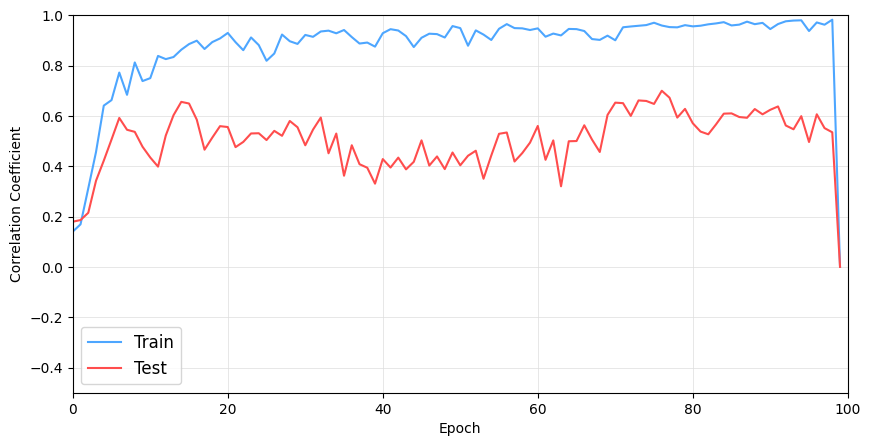

In [27]:
# Training/test learning curves of the correlation coefficient 
t1 = np.arange(0, n_epochs, 1)
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(t1, tr_cc.flatten(), label ='Train', color='#4da6ff')
plt.plot(t1, ts_cc.flatten(), label ='Test' , color='#ff4d4d')

plt.axis([0, n_epochs, -0.5, 1])
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.xlabel('Epoch')
plt.ylabel('Correlation Coefficient')
plt.legend(loc = 'best', fontsize='large')

print('CC for Train: %.2f' % tr_cc[n_epochs-2])  
print('CC fot Test:  %.2f' % ts_cc[n_epochs-2])
print('\n')

plt.show()


# **CC**

In [28]:
pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

def CC(y_test, y_pred):
  #being K.mean a scalar here, it will be automatically subtracted from all elements in y_pred
  fsp = y_pred - np.mean(y_pred) 
  fst = y_test - np.mean(y_test)

  devP = np.std(y_pred)
  devT = np.std(y_test)

  return np.mean(fsp * fst) / (devP * devT)


print('CC for Train: %.2f' % CC(y_train, pred_train))   
print('CC for Test:  %.2f' % CC(y_test, y_pred))


CC for Train: 0.98
CC for Test:  0.55


In [29]:
pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

def CC(y_test, y_pred):
  #being K.mean a scalar here, it will be automatically subtracted from all elements in y_pred
  fsp = y_pred - np.mean(y_pred) 
  fst = y_test - np.mean(y_test)

  devP = np.std(y_pred)
  devT = np.std(y_test)

  return np.mean(fsp * fst) / (devP * devT)


print('CC Train: %.2f' % CC(y_train, pred_train))   
print('CC Test:  %.2f' % CC(y_test, y_pred))


CC Train: 0.98
CC Test:  0.55


# **Predict**

### **MSE**

In [30]:
from sklearn import metrics

pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

train_mse = metrics.mean_squared_error(y_train, pred_train)
test_mse = metrics.mean_squared_error(y_test, y_pred)

print('\nMSE for Train: %.2f' % (train_mse))

y_pred = model.predict(x_test)
print('\nMSE for Test:  %.3f' % (test_mse))


MSE for Train: 0.01

MSE for Test:  0.037


## **RMSE**

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_train = model.predict(x_train)
print('RMSE for Train: %.2f' % (np.sqrt(mean_squared_error(y_train, pred_train)) ))


y_pred = model.predict(x_test)
print('RMSE for Test:  %.2f' % (np.sqrt(mean_squared_error(y_test, y_pred)) )) 

RMSE for Train: 0.08
RMSE for Test:  0.19


## **MAE**

In [32]:
from sklearn import metrics

pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

train_mae = metrics.mean_absolute_error(y_train, pred_train)
test_mae = metrics.mean_absolute_error(y_test, y_pred)

print('\nMAE for Train: %.2f' % (train_mae))

y_pred = model.predict(x_test)
print('\nMAE for Test:  %.2f' % (test_mae))



MAE for Train: 0.07

MAE for Test:  0.15


## **Accuracy**

In [33]:
train_diff = np.abs(pred_train.round(1) - y_train)
test_diff = np.abs(y_pred.round(1) - y_test)


print('\nAccuracy of Train: %.2f' %  (1 - train_diff.sum() / len(train_diff)) )
print('\nAccuracy of Test:  %.2f' %  (1 - test_diff.sum()  / len(test_diff))  )


Accuracy of Train: 0.94

Accuracy of Test:  0.86


# **Evaluate**

In [34]:
val_loss, test_mean_squard_error, test_mean_absolue_error, test_mape_error, RMSE, r2, val_mean_pred, val_STD_pred = model.evaluate(x_test, y_test)


print('\nMean for Test: %.2f' % val_mean_pred)
print('\nSE for Test:   %.2f' % ( val_STD_pred / np.sqrt(len(x_test)) ) )

#print('\nPearson_Correlation: ', Pearson_Correlation)


print('\n--------------------------------------')

print('\nLOSS for Test: %.2f' % val_loss)
print('\nMSE for Test:  %.2f' % test_mean_squard_error)
print('\nRMSE for Test:  %.2f' % RMSE)
print('\nMAE for Test:  %.2f' % test_mean_absolue_error)
print('\nMAPE for Test: %.2f' % test_mape_error)
print('\nCC for Test: %.2f' % r2)

16/16 [==============================] - 0s 319us/step

Mean for Test: 0.36

SE for Test:   0.02

--------------------------------------

LOSS for Test: 0.04

MSE for Test:  0.04

RMSE for Test:  0.15

MAE for Test:  0.15

MAPE for Test: 35.06

CC for Test: 0.89


In [35]:
print('%.2f' % np.mean(y_test))
print('%.2f' % np.mean(y_pred))


0.44
0.36
